In [11]:
%matplotlib inline

# On veut prédire si à dans un hub citibike à une certaine heure il y aura un vélo 

import mglearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

citibike = mglearn.datasets.load_citibike()
print("Données Citibike : \n{}".format(citibike.head()))

Données Citibike : 
starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64


Text(0, 0.5, 'Locations')

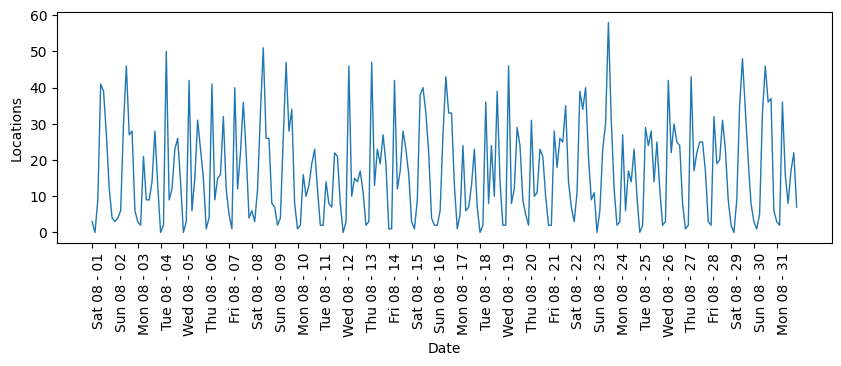

In [13]:
plt.figure(figsize=(10,3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(), freq='D')
plt.xticks(xticks, xticks.strftime("%a %m - %d"), rotation=90, ha="left")
plt.plot(citibike, linewidth=1)
plt.xlabel("Date")
###plt.ylabel("Locations")

Test set R^2: -0.04


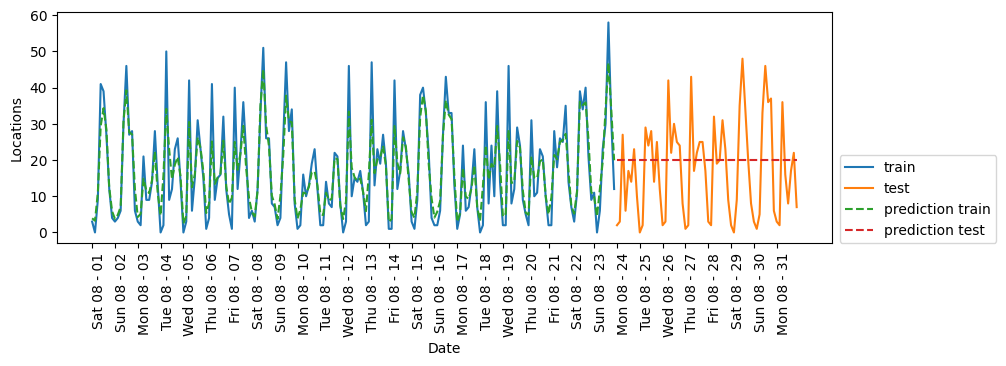

In [19]:
# On subdivise le jeu de données en test et entraînement ainsi [75%, 25%] dans l'ordre chronologique : 
# on essait de prévoir un avenir
y = citibike.values
X = citibike.index.astype("int64").values.reshape(-1,1)

n_train=184

def eval_on_features(features, target, regressor):
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train,y_train)
    print("Test set R^2: {:.2f}".format(regressor.score(X_test, y_test)))
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize=(10,3))
    
    plt.xticks(range(0,len(X), 8), xticks.strftime("%a %m - %d"), rotation=90, ha="left")
    plt.plot(range(n_train), y_train, label="train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="test")
    plt.plot(range(n_train), y_pred_train, '--', label="prediction train")
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label="prediction test")
    plt.legend(loc=(1.01,0))
    plt.xlabel("Date")
    plt.ylabel("Locations")
    
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X,y,regressor)

# Il faut qu'on puisse prévoir des données que le modèle d'apprentissage connait déjà, si on prend 
# les caractéristiques de temps en tant que timestamp unix, un modèle de forêt aléatoire va nous renvoyer 
# un courbe de prédiction plate valant la dernière prédiciton de l'échantillon d'entraînement


Test set R^2: 0.60


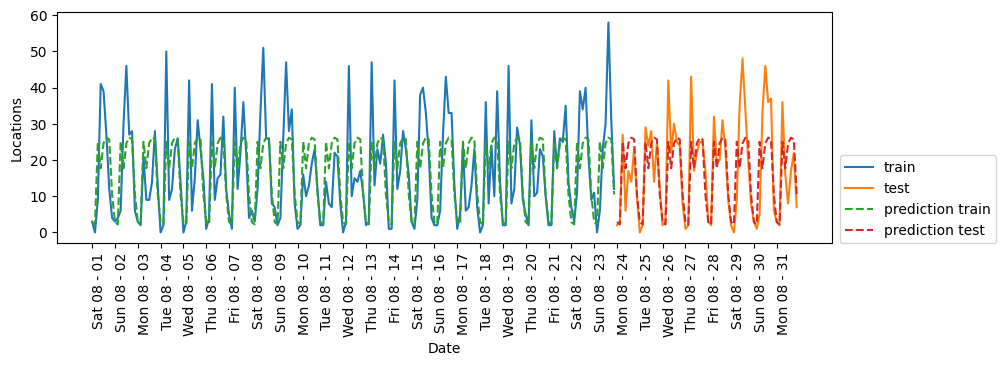

In [23]:
# La représentation cyclique des données heures, journées sera plus utile pour la prédiction via une forêt

# En n'utilisant que les heures : 

X_hour = citibike.index.hour.values.reshape(-1,1)
eval_on_features(X_hour,y,regressor)

Test set R^2: 0.84


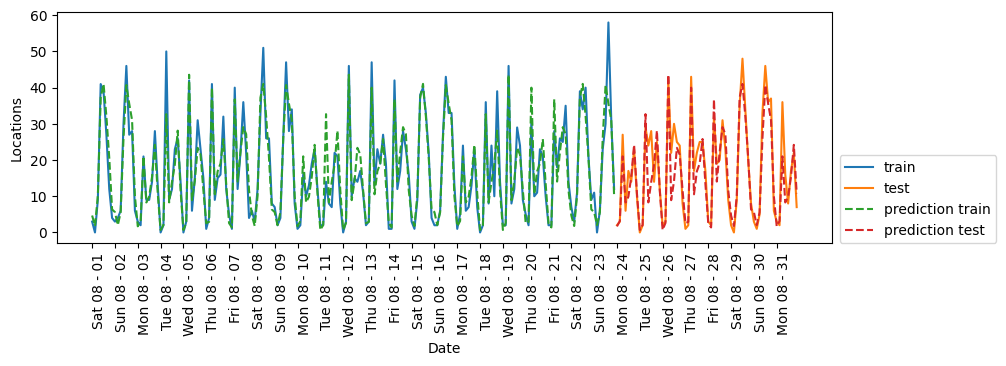

In [25]:
# En utilisant les jours et les heures : 
X_day_hour = np.hstack([ citibike.index.dayofweek.values.reshape(-1,1), X_hour] )
eval_on_features(X_day_hour, y, regressor)

Test set R^2: 0.13


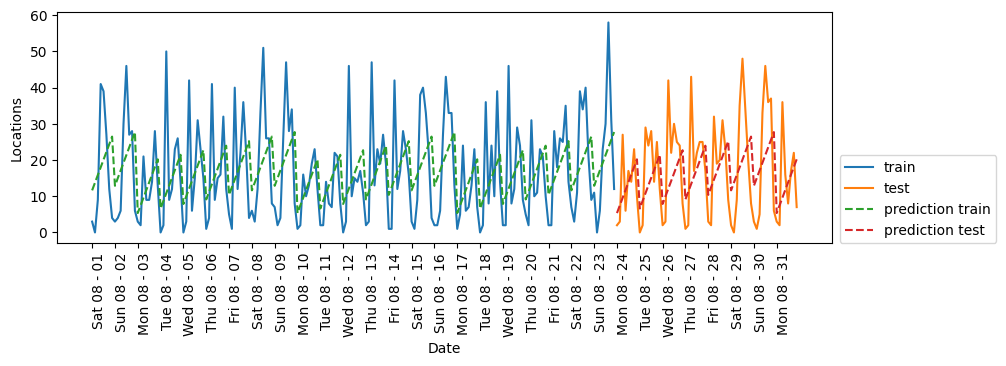

In [28]:
# Avec une régression linéaire

from sklearn.linear_model import LinearRegression
eval_on_features(X_day_hour,y, LinearRegression() )

# Les données sont interprétées comme des entiers et pas comme des variables catégorielles

Test set R^2: 0.62


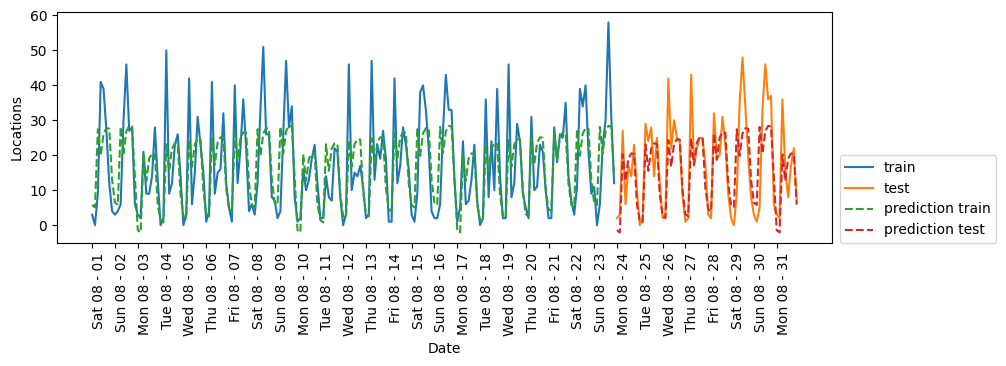

In [31]:
# Avec la transfo OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge

enc = OneHotEncoder()
X_day_hour_oh = enc.fit_transform(X_day_hour).toarray()
eval_on_features(X_day_hour_oh, y, Ridge() )

# Les caractéristiques sont considérées indépendantes : le motif heure est identiquement le même quelque soit 
# le jour considéré.

Test set R^2: 0.85


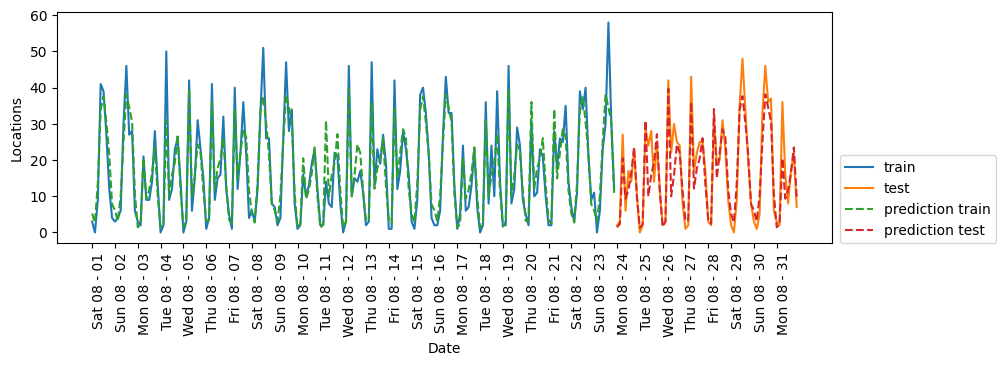

In [33]:
# En ajoutant des interactions polynomiales

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_day_hour_oh_poly = poly.fit_transform(X_day_hour_oh)
regressor = Ridge()
eval_on_features(X_day_hour_oh_poly, y, regressor)

Text(0, 0.5, 'Magnitude caractéristique')

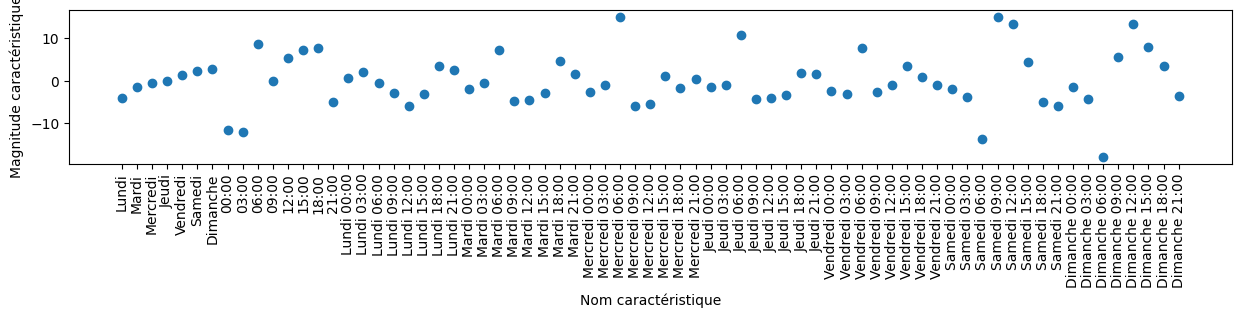

In [40]:
# On peut afficher les coefficients en fonction du jour et d'une place horaire de la semaine
hour = ["%02d:00"%i for i in range(0,24,3)]
day = ["Lundi","Mardi","Mercredi","Jeudi","Vendredi","Samedi","Dimanche"]
features = day + hour

features_poly = poly.get_feature_names_out(features)
features_nonzero = np.array(features_poly)[regressor.coef_ != 0]
coef_nonzero = regressor.coef_[regressor.coef_ != 0]

plt.figure(figsize=(15,2))
plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90)
plt.xlabel("Nom caractéristique")
plt.ylabel("Magnitude caractéristique")